# Lab 4

# 1. Instalacja biblioteki sorted containers

In [1]:
pip install sortedcontainers

Note: you may need to restart the kernel to use updated packages.


# 2. Narzędzie graficzne

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE =0.09 #0.002

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1: #POPRAWA NARZĘDZIA
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim()[1]- self.ax.get_xlim()[0],
                                                                    self.ax.get_ylim()[1]- self.ax.get_ylim()[0]])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else: 
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


# 3. Importowanie wykorzystywanych bibliotek

In [3]:
import random 
import math

# 4. Wprowadzanie danych 

### Funckcja wczytująca linie z wykresu

In [4]:
def lines_from_plot(plot):
    res = []
    lines_collection = plot.get_added_lines()
    for l in lines_collection:
        res = res + l.lines
    return res

### Funkcja zapisująca dane do pliku

In [5]:
def save_lines (lines, file):
    file = open(file + ".json", 'w')
    file.write(js.dumps({"lines":lines}))

### Funkcja wczytująca dane z pliku

In [6]:
def load_lines(file):
    file = open(file + ".json", "r")
    data = js.load(file)
    return data['lines']

### Funkcja generująca losowe dany

In [7]:
def give_me_lines(n, min_x, max_x, min_y, max_y):
    lines = []
    used_x = []
    i = 0
    while i < n:
        s1 = [random.uniform(min_x, max_x), random.uniform(min_y, max_y)]
        s2 = [random.uniform(min_x, max_x), random.uniform(min_y, max_y)]
        if s1[0] in used_x or s2[0] in used_x or s1[0] == s2[0]:
            continue
        else:
            if s1[0] < s2[0]:
                lines.append([s1, s2])
            else:
                lines.append([s2, s1])
            used_x.append(s1[0])
            used_x.append(s2[0])
            i += 1
            
    return lines

### Interaktywne wprowadzanie danych

<IPython.core.display.Javascript object>


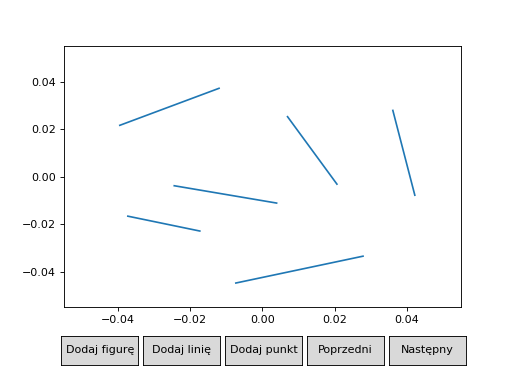

In [8]:
%matplotlib notebook
plot = Plot()
plot.draw()

In [9]:
lines = lines_from_plot(plot)

In [11]:
save_lines(lines,"lines")

### wizualizacja wprowadzonych interaktywnie danych

<IPython.core.display.Javascript object>


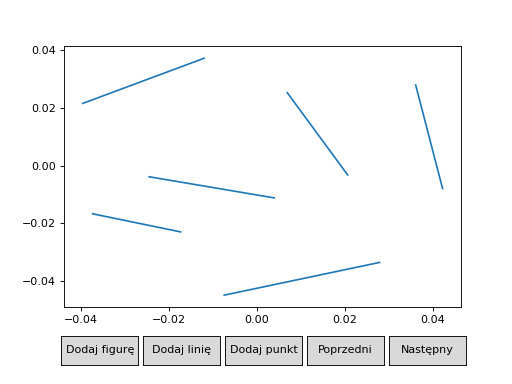

In [14]:
scene = Scene([PointsCollection([])],[LinesCollection(lines)])
plot = Plot([scene])
plot.draw()

### randomowe generowanie danych

<IPython.core.display.Javascript object>


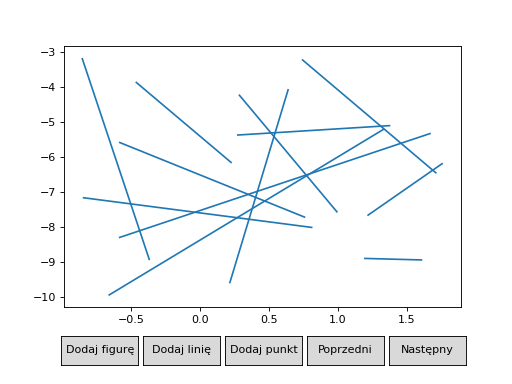

In [21]:
lines_1 = give_me_lines(12,-1.0,2.0,-10.0,-3.0)
scene = Scene([PointsCollection([])],[LinesCollection(lines_1)])
plot = Plot([scene])
plot.draw()

# 5. Algorytm sprawdzający czy w zbiorze choć jedna para się przecina

In [10]:
# determinant
def my_determinant(a, b, c):
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c
    return a_x*b_y + b_x*c_y + a_y*c_x - b_y*c_x - c_y*a_x - a_y*b_x

In [11]:
def sgn(x):
    return math.copysign(1, x)

In [12]:
def line_segment_intersection(line_a, line_b):
    if line_a.p2[0] < line_b.p1[0] or line_b.p2[0] < line_a.p1[0]:
        return False
    
    if ((min(line_a.p1[1], line_a.p2[1])> max(line_b.p1[1], line_b.p2[1])) or 
        (min(line_b.p1[1], line_b.p2[1])> max(line_a.p1[1], line_a.p2[1]))):
        return False
    
    if not (sgn(my_determinant(line_a.p1, line_a.p2, line_b.p1)) + sgn(my_determinant(line_a.p1, line_a.p2, line_b.p2)) == 0):
        return False
    
    if not (sgn(my_determinant(line_b.p1, line_b.p2, line_a.p1)) + sgn(my_determinant(line_b.p1, line_b.p2, line_a.p2)) == 0):
        return False
    
    return True

In [13]:
class Line:
    def __init__(self,line,id,X):
        self.id = id
        
        if line[0][0] < line[1][0]:
            self.p1 = line[0]
            self.p2 = line[1]
        else:
            self.p1 = line[1]
            self.p2 =  line[0]
            
        self.a = (self.p2[1] - self.p1[1])/(self.p2[0] - self.p1[0])
        self.b = self.p1[1] - self.p1[0] * self.a 
        self.X = X
        
    def calculate_y(self,x):
        return self.a * x + self.b
    
    def to_raw_line(self):
        return [self.p1, self.p2]
    
    def __eq__ (self, other):  
        return self.id == other.id 
    
    def __gt__(self,other):
        if(self.id == other.id):
            return False
        return other.calculate_y(self.X.val) < self.calculate_y(self.X.val)
    
    def __lt__(self,other):
        if(self.id == other.id):
            return False
        return other.calculate_y(other.X.val) > self.calculate_y(self.X.val)
    
    def __hash__(self):
        return self.id

In [14]:
# funkcja pomocna w wizualizacji
def state_struct_to_lines(state_struct):
    lines = []
    for l in state_struct:
        lines.append(l.to_raw_line())
    return lines

class X_cord:
    def __init__ (self, x):
        self.val = x

In [15]:
from sortedcontainers import SortedSet

def check_intersection(raw_lines):
    x_cord = X_cord(None)
    event_struct = [None for _ in  range(len(raw_lines)* 2)]
    min_y = raw_lines[0][0][1]
    max_y = raw_lines[0][0][1]
    lines = [Line(raw_line, i, x_cord) for (i, raw_line) in enumerate(raw_lines)]
    
    # używane do rysowania miotły
    for line in raw_lines:
        if line[0][1] > max_y:
            max_y = line[0][1] 
        if line[1][1] > max_y:
            max_y = line[1][1] 
            
        if line[0][1] < min_y:
            min_y = line[0][1] 
        if line[1][1] < min_y:
            min_y = line[1][1] 
            
    scenes=[Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black")])]

    for (i,line) in enumerate(lines):
        event_struct[i*2] = (True, line.p1[0], line) # (is start of line, x cord of event, line of event)
        event_struct[i*2 +1] = (False, line.p2[0], line)
        
    event_struct = sorted(event_struct, key = lambda x: x[1]) # lista
    state_struct = SortedSet() 
    
    for eve in event_struct:
        x_cord.val = eve[1]
        scenes.append(Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black"), 
                        LinesCollection(state_struct_to_lines(state_struct), color = "violet"),                     
                        LinesCollection([[(eve[1], min_y),(eve[1],max_y)]], color = "darkmagenta")]))
        
    
        if eve[0]:
     
            state_struct.add(eve[2])
            line_id = state_struct.index(eve[2])
            if line_id - 1 >= 0:
                if line_segment_intersection(eve[2], state_struct[line_id - 1]):
                    
                    scenes.append(Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black"), 
                    LinesCollection([[(eve[1], min_y),(eve[1],max_y)]], color = "darkmagenta"),
                    LinesCollection(state_struct_to_lines(state_struct), color = "violet"),     
                    LinesCollection([[eve[2].p1,eve[2].p2],[state_struct[line_id - 1].p1,state_struct[line_id - 1].p2]], 
                    color = "deeppink")])) 
                    
                    return (True, scenes) 
                
            if line_id + 1 < len(state_struct):
                  if line_segment_intersection(eve[2], state_struct[line_id + 1]):
                  
                    scenes.append(Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black"), 
                    LinesCollection([[(eve[1], min_y),(eve[1],max_y)]], color = "darkmagenta"),
                    LinesCollection(state_struct_to_lines(state_struct), color = "violet"),
                    LinesCollection([[eve[2].p1,eve[2].p2],[state_struct[line_id + 1].p1,state_struct[line_id + 1].p2]], 
                    color = "deeppink")])) 
                    
                    return (True, scenes) 
                   
            
        else:
            line_id = state_struct.index(eve[2])
            if line_id - 1 >= 0 and line_id + 1 < len(state_struct):
                 if line_segment_intersection( state_struct[line_id + 1], state_struct[line_id - 1]):
                        
                    scenes.append(Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black"), 
                    LinesCollection([[(eve[1], min_y),(eve[1],max_y)]], color = "darkmagenta"),
                    LinesCollection(state_struct_to_lines(state_struct), color = "violet"),
                    LinesCollection([[state_struct[line_id - 1].p1,state_struct[line_id - 1].p2],
                    [state_struct[line_id + 1].p1,state_struct[line_id + 1].p2]], color = "deeppink")])) 
                    
                    return (True, scenes)
                    
            state_struct.remove(eve[2])
         
    return (False, scenes)

<IPython.core.display.Javascript object>


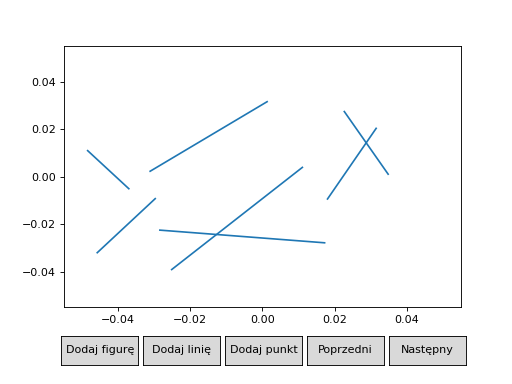

In [36]:
%matplotlib notebook
plot = Plot()
plot.draw()


In [37]:
lines_2 = lines_from_plot(plot)

True


<IPython.core.display.Javascript object>


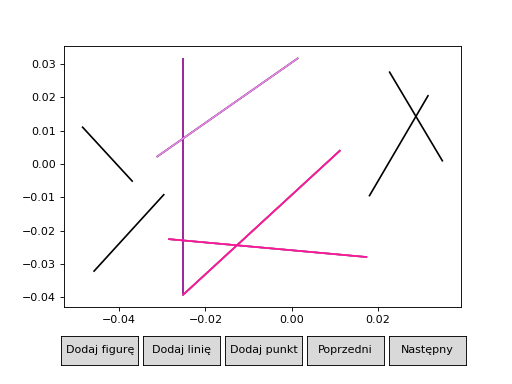

In [44]:
(res, scenes) = check_intersection(lines_2)
print(res)
plot = Plot(scenes)
plot.draw()

# 6. Algorytm wykrywający wszystkie przecięcia w zbiorze

In [16]:
class Line:
    def __init__(self,line,id,X):
        self.id = id
        
        if line[0][0] < line[1][0]:
            self.p1 = line[0]
            self.p2 = line[1]
        else:
            self.p1 = line[1]
            self.p2 =  line[0]
            
        self.a = (self.p2[1] - self.p1[1])/(self.p2[0] - self.p1[0])
        self.b = self.p1[1] - self.p1[0] * self.a 
        self.X = X
        
    def calculate_y(self,x):
        return self.a * x + self.b
    
    def to_raw_line(self):
        return [self.p1, self.p2]
    
    def __eq__ (self, other):  
        return self.id == other.id 
    
    def __gt__(self,other):
        if(self.id == other.id):
            return False
        return other.calculate_y(self.X.val) < self.calculate_y(self.X.val)
    
    def __lt__(self,other):
        if(self.id == other.id):
            return False
        return other.calculate_y(other.X.val) > self.calculate_y(self.X.val)
    
    def __hash__(self):
        return self.id

In [17]:
def find_intersection_point(line1, line2):
    # lines have formula of y = ax + b
    x = (line2.b-line1.b)/(line1.a - line2.a)
    y = (line2.b-line1.b)/(line1.a - line2.a) * line1.a + line1.b
    return [x,y]

In [18]:
class Line_event:
    def __init__ (self, type, x, line):
        self.x = x
        self.line = line
        self.type = type # B - beginning, E - ending, I - intersection
        self.line2 = None
        self.y = None
    
    def __eq__(self, other):
        # zdarzenie początku lub końca - 1 dla linii
        if self.type == other.type and self.line == other.line and self.line2 is None and other.line2 is None:
            return True
        # zdarzenie przecięcia - 1 dla pary linii
        if other.line2 is not None and self.line2 is not None:
            if (self.line == other.line and self.line2 == other.line2) or(self.line == other.line2 and self.line2 == other.line):
                return True
        return False
    
    def __hash__(self):
        return self.x.__hash__()
    
    def to_point(self):
        return [self.x,self.y]


In [19]:
class X_cord:
    def __init__ (self, x):
        self.val = x

In [20]:
class Visualizer:
    def __init__(self, min_y, max_y, raw_lines, state_struct):
        self.min_y = min_y
        self.max_y = max_y
        self.raw_lines = raw_lines
        self.state_struct = state_struct
        self.eve = None # current event
        self.scenes =[Scene([PointsCollection([])],[LinesCollection(raw_lines, color = "black")])]
        
    def add_scene(self, res_points,x):
        self.scenes.append(Scene([PointsCollection(res_points.copy(), color = "crimson")],[LinesCollection(self.raw_lines, color = "black"), 
                        LinesCollection(self.state_struct.to_lines(), color = "violet"),                     
                        LinesCollection([[(x, self.min_y),(x,self.max_y)]], color = "deeppink")]))
            
    def add_scene_with_line(self, res_points, x, lines):
        raw_lines = [l.to_raw_line() for l in lines]
        self.scenes.append(Scene([PointsCollection(res_points.copy(), color = "crimson")],[LinesCollection(self.raw_lines, color = "black"), 
                        LinesCollection(self.state_struct.to_lines() + raw_lines, color = "violet"),                     
                        LinesCollection([[(x, self.min_y),(x,self.max_y)]], color = "deeppink")]))

In [21]:
class State_struct:
    def __init__(self, x):
        self.lines = SortedSet()
    
    def add(self, line, event_struct,x,res,res_points, visualizer):
        self.lines.add(line)
        line_id = self.lines.index(line)

        if line_id -1>= 0:
            if line_segment_intersection(line, self.lines[line_id - 1]):
                (i_x, i_y) = find_intersection_point(line, self.lines[line_id - 1])
                eve = Line_event('I', i_x,line)
                eve.y = i_y
                eve.line2 = self.lines[line_id - 1]
                if eve not in res and eve not in event_struct:
                    event_struct.add(eve)
                    res_points.append(eve.to_point())
                    visualizer.add_scene(res_points, x)        
 
        if line_id + 1 < len(self.lines):
            if line_segment_intersection(line, self.lines[line_id + 1]):
                (i_x, i_y) = find_intersection_point(line, self.lines[line_id + 1])
                eve = Line_event('I', i_x,line)
                eve.y = i_y
                eve.line2 = self.lines[line_id + 1]
                if eve not in res and eve not in event_struct :
                    event_struct.add(eve)
                    res_points.append(eve.to_point())
                    visualizer.add_scene(res_points, x)
            
            
    def remove(self, line, event_struct, x,res,res_points, visualizer, extra_lines = None):
        # extra lines rysuje linie, których pozornie nie ma w strukturze stanu- zostały chwilowo wyciągniete do 
        #zamiany kolejności na skutek przeccięcia
        line_id = self.lines.index(line)
        if line_id - 1 >= 0 and line_id + 1 < len(self.lines):
            if line_segment_intersection(self.lines[line_id + 1], self.lines[line_id - 1]):
                (i_x, i_y) = find_intersection_point(self.lines[line_id + 1], self.lines[line_id - 1])
                eve = Line_event('I', i_x,self.lines[line_id - 1])
                eve.y = i_y
                eve.line2 = self.lines[line_id + 1]
                if eve not in res and eve not in event_struct :
                    event_struct.add(eve)
                    res_points.append(eve.to_point())
                    if extra_lines == None:
                        visualizer.add_scene(res_points, x)
                    else:
                        visualizer.add_scene_with_line(res_points, x, extra_lines)
                    
        self.lines.remove(line)
   

    
    def interection(self,line1, line2, event_struct, x, res, res_points, visualizer, epsilon, x_cord):
        
        if line1.calculate_y(x-epsilon)< line2.calculate_y(x-epsilon):
            line1, line2 = line2, line1 #line1 będzie odcinkiem "wyższym" przed przecięciem
       
        x_cord.val = x - epsilon
        
        # usunięcie lini
        # self.remove automatycznie wykryje przecięcie line2 z linią nad line1
        self.remove(line1,event_struct, x, res,res_points, visualizer, [line1,line2])
        self.lines.remove(line2)
        x_cord.val = x + epsilon
        # dodanie linii 1. i sprawdzenie czy nie ma nowego przecięcia
        self.lines.add(line1)
         
        line_id = self.lines.index(line1)
        if line_id -1 >= 0:
            if line_segment_intersection(self.lines[line_id-1], self.lines[line_id]):
                (i_x, i_y) = find_intersection_point(self.lines[line_id], self.lines[line_id - 1])
                eve = Line_event('I', i_x,self.lines[line_id - 1])
                eve.y = i_y
                eve.line2 = self.lines[line_id]
                if eve not in res and eve not in event_struct :
                    event_struct.add(eve)
                    res_points.append(eve.to_point())
                    visualizer.add_scene_with_line(res_points,x, [line2]) # linia 2. nie jest tymczasowo w zbiorze,
                    # ale powinna zostać narysowana
                    
        # dodanie lini 2.
        self.lines.add(line2)
    def to_lines(self):
        res = []
        for l in self.lines:
            res.append(l.to_raw_line())
        return res
    

In [22]:
from sortedcontainers import SortedSet

def find_intersections(raw_lines):
    epsilon = 10**(-10)
    res = SortedSet(key = lambda event : event.x) 
    
    x_cord = X_cord(None)
    res_points = []
    event_struct = SortedSet(key = lambda event : event.x)
    min_y = raw_lines[0][0][1]
    max_y = raw_lines[0][0][1]
    lines = [Line(raw_line, i, x_cord) for (i, raw_line) in enumerate(raw_lines)]
    
    for line in raw_lines:
        if line[0][1] > max_y:
            max_y = line[0][1] 
        if line[1][1] > max_y:
            max_y = line[1][1] 
            
        if line[0][1] < min_y:
            min_y = line[0][1] 
        if line[1][1] < min_y:
            min_y = line[1][1] 
            
   

    for line in lines:
        event_struct.add(Line_event('B', line.p1[0], line)) 
        event_struct.add(Line_event('E', line.p2[0], line)) 
    
    state_struct = State_struct(event_struct[0].x) # SortedSet
    
    vis = Visualizer(min_y, max_y, raw_lines,state_struct)

    while len(event_struct)> 0:
        eve = event_struct[0]
        x_cord.val = eve.x
        vis.add_scene(res_points, eve.x)

        if eve.type == 'B':
            state_struct.add(eve.line, event_struct, eve.x, res, res_points,vis)          
            
        elif eve.type == 'E':
            state_struct.remove(eve.line, event_struct, eve.x,res, res_points, vis) 
            
        else: # intersection
            res.add(eve)      
            state_struct.interection(eve.line, eve.line2, event_struct, eve.x, res, res_points, vis, epsilon, x_cord)
        
            
        event_struct.remove(eve)
    
    scenes = vis.scenes
    scenes.append(Scene([PointsCollection(res_points, color = "crimson")],[LinesCollection(raw_lines, color = "black")]))  
    return (res, vis.scenes)

Liczba punktów przecięcia:  2 

Punkt przecięcia  (-0.012714276816322118, -0.024369635355335866)  przecinający linie  [(-0.02532903855846775, -0.03935669186360693), (0.011263703377016127, 0.004117572842275444)] i [(-0.028655651461693556, -0.022506201667528494), (0.017473380796370966, -0.027898358530273594)] 

Punkt przecięcia  (0.02877392918346774, 0.014249435587373474)  przecinający linie  [(0.022574187247983865, 0.02770825911678526), (0.034993542086693544, 0.0007474748030597556)] i [(0.01791692918346774, -0.009699829118508876), (0.03166692918346774, 0.020631053234432317)] 



<IPython.core.display.Javascript object>


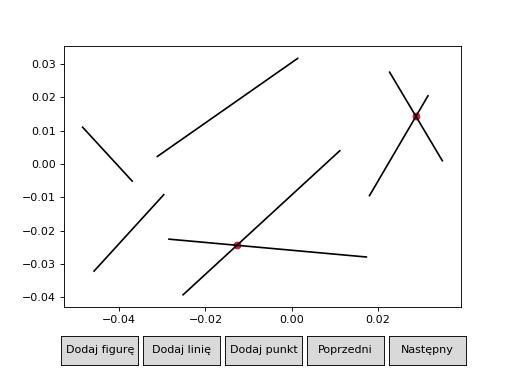

In [65]:
(res, scenes) =find_intersections(lines_2)
print("Liczba punktów przecięcia: ",len(res), "\n")
for eve in res:
    print("Punkt przecięcia ",(eve.x,eve.y)," przecinający linie ", eve.line.to_raw_line(),"i", eve.line2.to_raw_line(), "\n")
plot = Plot(scenes)
plot.draw()

# 7. Testy

## test 1

<IPython.core.display.Javascript object>


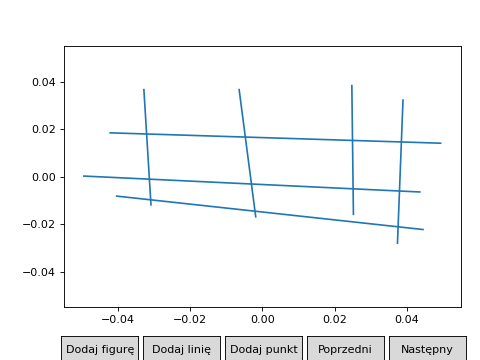

In [67]:
%matplotlib notebook
plot = Plot()
plot.draw()


In [68]:
lines_t_1 = lines_from_plot(plot)

In [71]:
(res, scenes) = check_intersection(lines_t_1)
print(res)

True


Liczba punktów przecięcia:  11 

Punkt przecięcia  (-0.03209755041899948, 0.01796954816388696)  przecinający linie  [(-0.03286936113911291, 0.03699577539282693), (-0.03087339339717743, -0.01220765597972212)] i [(-0.04240565146169356, 0.01846023617714064), (0.0496306388608871, 0.01407910872616025)] 

Punkt przecięcia  (-0.03132546878396754, -0.0010633575014430408)  przecinający linie  [(-0.049724199848790326, 0.00026170676537592974), (0.043864509828629036, -0.006478489313055447)] i [(-0.03286936113911291, 0.03699577539282693), (-0.03087339339717743, -0.01220765597972212)] 

Punkt przecięcia  (-0.03097249109349218, -0.00976475743113514)  przecinający linie  [(-0.04063145791330646, -0.008163538332663284), (0.04475160660282258, -0.02231795009736917)] i [(-0.03286936113911291, 0.03699577539282693), (-0.03087339339717743, -0.01220765597972212)] 

Punkt przecięcia  (-0.0047333176046389265, 0.01666695120851401)  przecinający linie  [(-0.006478232106854845, 0.03699577539282693), (-0.00182097404

<IPython.core.display.Javascript object>


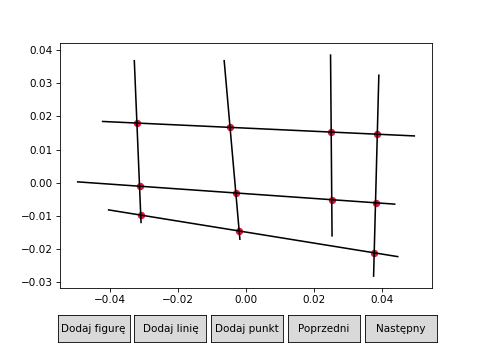

In [90]:
(res, scenes) =find_intersections(lines_t_1)
print("Liczba punktów przecięcia: ",len(res), "\n")
for eve in res:
    print("Punkt przecięcia ",(eve.x,eve.y)," przecinający linie ", eve.line.to_raw_line(),"i", eve.line2.to_raw_line(), "\n")
plot = Plot(scenes)
plot.draw()

## test 2

<IPython.core.display.Javascript object>


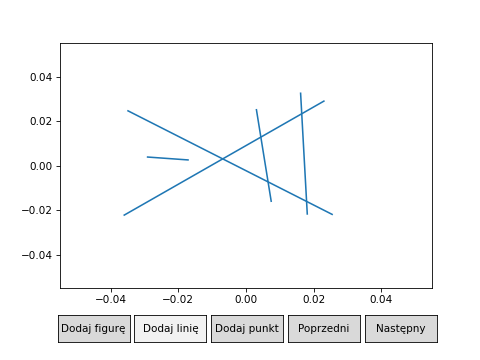

In [8]:
%matplotlib notebook
plot = Plot()
plot.draw()

In [23]:
lines_t_2 = lines_from_plot(plot)
(res, scenes) = check_intersection(lines_t_2)
print(res)

True


Liczba punktów przecięcia:  5 

Punkt przecięcia  (-0.006886264618679806, 0.0030194175105358653)  przecinający linie  [(-0.035095766129032265, 0.024766007965686274), (0.025670362903225816, -0.022078354779411766)] i [(-0.0362046370967742, -0.022415364583333333), (0.023230846774193556, 0.029147135416666678)] 

Punkt przecięcia  (0.004390722051069643, 0.012802624229628204)  przecinający linie  [(0.0030493951612903247, 0.025440027573529422), (0.007484879032258071, -0.016349188112745106)] i [(-0.0362046370967742, -0.022415364583333333), (0.023230846774193556, 0.029147135416666678)] 

Punkt przecięcia  (0.00652657792665727, -0.007320488480565011)  przecinający linie  [(-0.035095766129032265, 0.024766007965686274), (0.025670362903225816, -0.022078354779411766)] i [(0.0030493951612903247, 0.025440027573529422), (0.007484879032258071, -0.016349188112745106)] 

Punkt przecięcia  (0.016481520949916645, 0.02329184342359064)  przecinający linie  [(0.01613407258064517, 0.032854243259803934), (0.0181

<IPython.core.display.Javascript object>


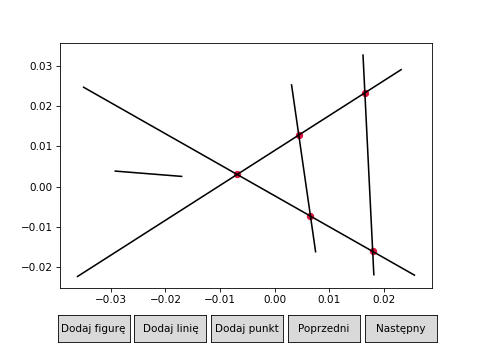

In [31]:
(res, scenes) =find_intersections(lines_t_2)
print("Liczba punktów przecięcia: ",len(res), "\n")
for eve in res:
    print("Punkt przecięcia ",(eve.x,eve.y)," przecinający linie ", eve.line.to_raw_line(),"i", eve.line2.to_raw_line(), "\n")
plot = Plot(scenes)
plot.draw()

## test 3

<IPython.core.display.Javascript object>


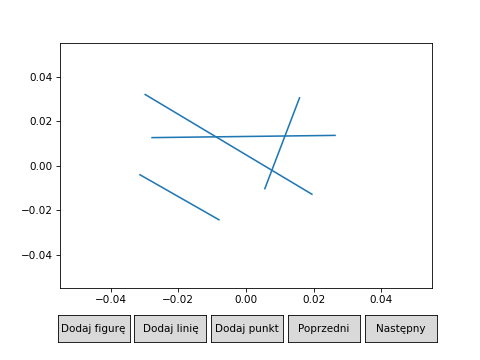

In [25]:
%matplotlib notebook
plot = Plot()
plot.draw()

In [26]:
lines_t_3 = lines_from_plot(plot)
(res, scenes) = check_intersection(lines_t_3)
print(res)

True


Liczba punktów przecięcia:  3 

Punkt przecięcia  (-0.008882499525278217, 0.012924728757004051)  przecinający linie  [(-0.027998991935483872, 0.012570465686274512), (0.026557459677419362, 0.013581495098039215)] i [(-0.02999495967741936, 0.03211703431372549), (0.019682459677419356, -0.01304227941176471)] 

Punkt przecięcia  (0.007646875744508509, -0.0021013183523039963)  przecinający linie  [(0.0054889112903225845, -0.010683210784313724), (0.015912298387096777, 0.030768995098039223)] i [(-0.02999495967741936, 0.03211703431372549), (0.019682459677419356, -0.01304227941176471)] 

Punkt przecięcia  (0.011520334305081155, 0.013302830053477712)  przecinający linie  [(0.0054889112903225845, -0.010683210784313724), (0.015912298387096777, 0.030768995098039223)] i [(-0.027998991935483872, 0.012570465686274512), (0.026557459677419362, 0.013581495098039215)] 



<IPython.core.display.Javascript object>


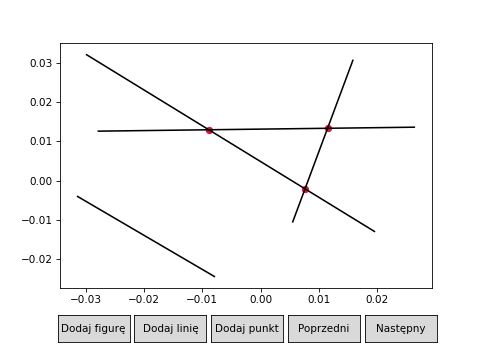

In [27]:
(res, scenes) =find_intersections(lines_t_3)
print("Liczba punktów przecięcia: ",len(res), "\n")
for eve in res:
    print("Punkt przecięcia ",(eve.x,eve.y)," przecinający linie ", eve.line.to_raw_line(),"i", eve.line2.to_raw_line(), "\n")
plot = Plot(scenes)
plot.draw()

## test 4

<IPython.core.display.Javascript object>


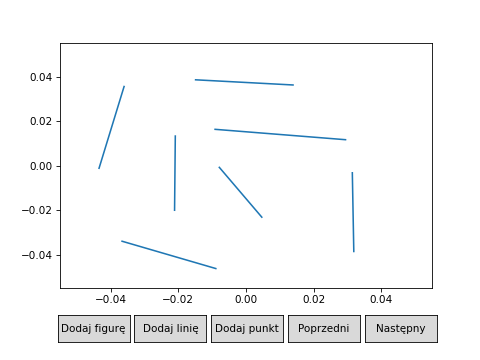

In [28]:
%matplotlib notebook
plot = Plot()
plot.draw()

In [29]:
lines_t_4 = lines_from_plot(plot)
(res, scenes) = check_intersection(lines_t_4)
print(res)

False


Liczba punktów przecięcia:  0 



<IPython.core.display.Javascript object>


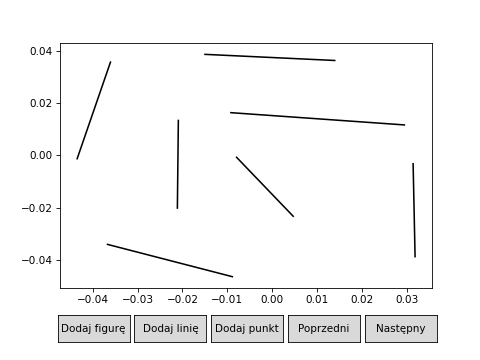

In [30]:
(res, scenes) =find_intersections(lines_t_4)
print("Liczba punktów przecięcia: ",len(res), "\n")
for eve in res:
    print("Punkt przecięcia ",(eve.x,eve.y)," przecinający linie ", eve.line.to_raw_line(),"i", eve.line2.to_raw_line(), "\n")
plot = Plot(scenes)
plot.draw()